In [68]:
from kapre.composed import get_melspectrogram_layer
import numpy as np
from librosa import load
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Dense, InputLayer, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from typing import Tuple
import utils.constants as consts
from utils.audio_tools import create_audio_player
from utils.displays import display_mel_spectrogram

# Load sample.
path_to_audio: str = '/media/audio/string_G_020508_segment_2.wav'
sample: np.ndarray = load(path_to_audio)[0]

In [3]:
create_audio_player(sample)

Create __kapre__ mel spectrogram layer.

In [36]:
input_shape: Tuple[int, int] = (consts.SAMPLE_RATE, 1)

# Encoding layer.
composed_mel_spec_layer: Sequential = get_melspectrogram_layer(
    input_shape=input_shape,
    n_mels=consts.NUM_MELS,
    pad_end=True,
    n_fft=consts.NUM_FFT,
    win_length=consts.MEL_WINDOW_LEN,
    hop_length=consts.MEL_HOP_LEN,
    sample_rate=consts.SAMPLE_RATE,
    return_decibel=False,
    input_data_format='channels_last',
    output_data_format='channels_last',
    name='mel_spec_layer'
)

x = LayerNormalization(axis=2, name='batch_norm')(composed_mel_spec_layer.output)

output = Dense(1, activation=softmax, name='output')(x)
model = Model(inputs=composed_mel_spec_layer.input, outputs=output, name='2d_convolution')

model.summary()

Model: "2d_convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft_12_input (InputLayer)   [(None, 22050, 1)]        0         
_________________________________________________________________
stft_12 (STFT)               (None, 44, 1025, 1)       0         
_________________________________________________________________
magnitude_12 (Magnitude)     (None, 44, 1025, 1)       0         
_________________________________________________________________
apply_filterbank_12 (ApplyFi (None, 44, 128, 1)        0         
_________________________________________________________________
batch_norm (LayerNormalizati (None, 44, 128, 1)        256       
_________________________________________________________________
output (Dense)               (None, 44, 128, 1)        2         
Total params: 258
Trainable params: 258
Non-trainable params: 0
______________________________________________________

In [37]:
reshaped_sample: np.ndarray = sample.reshape((1, consts.SAMPLE_RATE, 1))
reshaped_sample.shape

(1, 22050, 1)

In [87]:
# from tensorflow.keras.backend import function
#
# get_all_layer_outputs = function([model.layers[0].input], [l.output for l in model.layers[1:]])
# layer_output = get_all_layer_outputs([reshaped_sample])
#
# print(layer_output[0][0][0].name)

layer_name: str = 'apply_filterbank_12'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output: np.ndarray = intermediate_layer_model(reshaped_sample).numpy()[0].reshape(44, 128)

print(intermediate_output.shape)

(44, 128)


<Figure size 640x480 with 0 Axes>

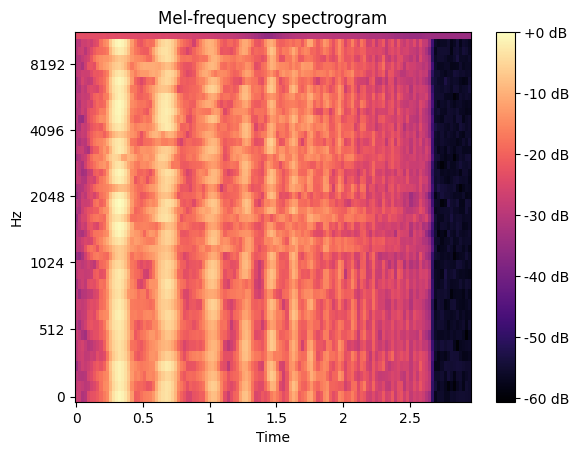

In [88]:
display_mel_spectrogram(intermediate_output, is_log_mel=False)